In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
SAVE_DIR = "/content/drive/MyDrive/rl_final_project/reinforce/trivia"
os.makedirs(SAVE_DIR, exist_ok=True)

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

!pip install torch transformers datasets sentence-transformers faiss-cpu peft bitsandbytes -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import faiss
from typing import List
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model
from sentence_transformers import SentenceTransformer

MODEL_ID = "HuggingFaceTB/SmolLM2-1.7B-Instruct"
MAX_SEQ_LEN = 512
GENERATE_LEN = 64
LR = 1e-5
MAX_STEPS = 5
NUM_EPISODES = 10000
PRINT_EVERY = 50
SAVE_EVERY = 500
GAMMA = 0.99  

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


### CELL 2: SEARCH MODULES

*This remains exactly the same. The environment logic doesn't change.*

In [4]:
import string
import re

class E5Retriever:
    def __init__(self, model_name="intfloat/e5-small-v2"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = SentenceTransformer(model_name, device=self.device)
        self.index = None
        self.docs = []

    def build_index(self, docs: List[str]):
        print(f"Building index for {len(docs)} docs...")
        self.docs = docs
        embs = self.model.encode(["passage: " + d for d in docs],
                                 normalize_embeddings=True, show_progress_bar=False)
        self.index = faiss.IndexFlatIP(embs.shape[1])
        self.index.add(embs)

    def search(self, query: str, k=1):
        q_emb = self.model.encode(["query: " + query], normalize_embeddings=True)
        D, I = self.index.search(q_emb, k)
        return [self.docs[i] for i in I[0]]

class SearchR1Environment:
    def __init__(self, retriever):
        self.retriever = retriever

    def normalize_answer(self, s):
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)

        def white_space_fix(text):
            return ' '.join(text.split())

        def remove_punc(text):
            exclude = set(string.punctuation)
            return ''.join(ch for ch in text if ch not in exclude)

        def lower(text):
            return text.lower()

        return white_space_fix(remove_articles(remove_punc(lower(s))))

    def check_correctness(self, prediction, truth):
        pred_norm = self.normalize_answer(prediction)
        truth_norm = self.normalize_answer(truth)

        if pred_norm == truth_norm:
            return True

        if pred_norm in truth_norm and len(pred_norm) > 0:
            return True

        if truth_norm in pred_norm and len(truth_norm) > 0:
            return True

        return False

    def reset(self, question, answer):
        self.question = question
        self.ground_truth = answer
        self.history = []
        self.search_count = 0
        return self._format_prompt()

    def step(self, action):
        if action['type'] == 'search':
            if self.search_count >= 2: return self._format_prompt(), 0.0, False
            results = self.retriever.search(action['content'])
            context = f"\n<information>{results[0][:200]}</information>"
            self.history.append({'type': 'search', 'query': action['content'], 'result': context})
            self.search_count += 1
            return self._format_prompt(), 0.0, False

        elif action['type'] == 'answer':
            is_correct = self.check_correctness(action['content'], self.ground_truth)
            reward = 1.0 if is_correct else 0.0
            return self._format_prompt(), reward, True

        else:
            self.history.append({'type': 'think', 'content': action['content']})
            return self._format_prompt(), 0.0, False

    def _format_prompt(self):
        prompt = f"<|im_start|>user\n{self.question}\nUse <search>...</search> to search. <answer>...</answer> to finish.<|im_end|>\n<|im_start|>assistant\n"
        for h in self.history:
            if h['type'] == 'think': prompt += f"<think>{h['content']}</think>\n"
            elif h['type'] == 'search': prompt += f"<search>{h['query']}</search>\n{h['result']}\n"
        return prompt

print("Environment Ready (With Normalization)")

Environment Ready (With Normalization)


### CELL 3: MODEL SETUP

*We remove the Value Head initialization. We only need the Policy network.*

In [5]:
print("Loading Model...")

CHECKPOINT_PATH = f"{SAVE_DIR}/final"

if os.path.exists(CHECKPOINT_PATH):
    print(f"Found checkpoint at {CHECKPOINT_PATH}, loading...")
    tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT_PATH)
    tokenizer.pad_token = tokenizer.eos_token
    base_model = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype=torch.float16, device_map="auto")
    from peft import PeftModel
    model = PeftModel.from_pretrained(base_model, CHECKPOINT_PATH)
    print("✓ Loaded from checkpoint")
else:
    print("No checkpoint found, loading fresh model...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype=torch.float16, device_map="auto")

    peft_config = LoraConfig(
        r=16,
        lora_alpha=32,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
    )
    model = get_peft_model(model, peft_config)
    print("✓ Loaded fresh model")

VOCAB_SIZE = len(tokenizer)
model.print_trainable_parameters()

Loading Model...
No checkpoint found, loading fresh model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


✓ Loaded fresh model
trainable params: 18,087,936 || all params: 1,729,464,320 || trainable%: 1.0459


### CELL 4: REINFORCE POLICY NETWORK

*Added `get_log_probs` which is critical for REINFORCE to calculate the gradient. Removed `get_hidden_state` (used for Value head).*

In [6]:
class ReinforcePolicyNetwork(nn.Module):
    def __init__(self, model, tokenizer):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.device = next(model.parameters()).device
        self.vocab_size = len(tokenizer)

    def generate(self, prompt):
        """Sampling generation for exploration"""
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=MAX_SEQ_LEN,
            padding=False
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_new_tokens=GENERATE_LEN,
                do_sample=True, 
                temperature=1.0,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id,
            )

        gen_seq = outputs[0][inputs['input_ids'].shape[1]:]
        text = self.tokenizer.decode(gen_seq, skip_special_tokens=False)
        return text

    def get_log_probs(self, prompt, generated_text):
        full_text = prompt + generated_text
        inputs = self.tokenizer(
            full_text,
            return_tensors="pt",
            truncation=True,
            max_length=MAX_SEQ_LEN
        ).to(self.device)

        input_ids = inputs['input_ids']

        outputs = self.model(input_ids)
        logits = outputs.logits[:, :-1, :]
        labels = input_ids[:, 1:]

        log_probs = F.log_softmax(logits, dim=-1)

        token_log_probs = torch.gather(log_probs, -1, labels.unsqueeze(-1)).squeeze(-1)

        prompt_len = len(self.tokenizer.encode(prompt, add_special_tokens=False))
        if self.tokenizer.bos_token_id is not None and input_ids[0][0] == self.tokenizer.bos_token_id:
             prompt_len += 1

        mask = torch.zeros_like(token_log_probs)
        mask[:, prompt_len-1:] = 1.0

        action_log_prob = (token_log_probs * mask).sum(dim=-1)
        return action_log_prob

policy = ReinforcePolicyNetwork(model, tokenizer)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

print("REINFORCE Policy Ready")

REINFORCE Policy Ready


### CELL 5: REINFORCE TRAINER

*Major logic change: No Value Head, calculating returns $G_t$, and simple loss $- \log \pi \cdot G_t$.*

In [7]:
class SearchR1ReinforceTrainer:
    def __init__(self, policy, optimizer, env, gamma=0.99):
        self.policy = policy
        self.optimizer = optimizer
        self.env = env
        self.gamma = gamma
        self.device = policy.device

    def parse_action(self, text):
        text_lower = text.lower()
        if "<answer>" in text_lower or "answer:" in text_lower:
            if "<answer>" in text:
                content = text.split("<answer>")[-1].split("</answer>")[0]
            else:
                content = text.split("answer:")[-1].split("\n")[0]
            return {'type': 'answer', 'content': content}
        if "<search>" in text_lower or "search:" in text_lower:
            if "<search>" in text:
                content = text.split("<search>")[-1].split("</search>")[0]
            else:
                content = text.split("search:")[-1].split("\n")[0]
            return {'type': 'search', 'content': content}
        return {'type': 'think', 'content': text[:100]}

    def train_step(self, question, answer):
        self.policy.model.train()
        self.optimizer.zero_grad()

        prompt = self.env.reset(question, answer)
        trajectory = []
        done = False

        for step_idx in range(MAX_STEPS):
            if done: break

            action_text = self.policy.generate(prompt)
            action = self.parse_action(action_text)

            next_prompt, reward, done = self.env.step(action)

            trajectory.append({
                "prompt": prompt,
                "action_text": action_text,
                "reward": reward
            })
            prompt = next_prompt

        if not trajectory:
            return 0.0, 0.0

        returns = []
        G = 0
        for step in reversed(trajectory):
            G = step['reward'] + self.gamma * G
            returns.insert(0, G)

        returns = torch.tensor(returns, device=self.device, dtype=torch.float32)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        policy_loss = 0

        for i, step in enumerate(trajectory):
            log_prob = self.policy.get_log_probs(step['prompt'], step['action_text'])
            policy_loss += -log_prob * returns[i]

        policy_loss = policy_loss / len(trajectory)

        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.model.parameters(), 1.0)
        self.optimizer.step()

        return policy_loss.item(), trajectory[-1]['reward']

print("✓ REINFORCE Trainer Ready")

✓ REINFORCE Trainer Ready


In [8]:
from matplotlib import pyplot as plt

def plot_results(data, title="Results", xlabel="Episode", ylabel="Value", window=100, save_path=None):
    fig, ax = plt.subplots(figsize=(10, 5))

    episodes = list(range(1, len(data) + 1))
    ax.plot(episodes, data, alpha=0.3, color='blue', label='Raw')

    if len(data) >= window:
        smoothed = np.convolve(data, np.ones(window)/window, mode='valid')
        ax.plot(range(window, len(data) + 1), smoothed, color='blue', linewidth=2, label=f'Smoothed (w={window})')

    cumulative_avg = np.cumsum(data) / np.arange(1, len(data) + 1)
    ax.plot(episodes, cumulative_avg, color='red', linestyle='--', linewidth=2, label='Cumulative Avg')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

    return cumulative_avg[-1] if len(data) > 0 else 0

In [9]:
def get_dataset(
    name,
    subset_size,
    ds_type
):

  if name == "gsm8k":
    if ds_type == 'train':
      train_ds = load_dataset("openai/gsm8k", "main", split="train")
      train_ds = train_ds.shuffle(seed=42).select(range(subset_size))
      questions = train_ds['question']
      answers = [a.split('####')[-1].strip() for a in train_ds['answer']]
      return questions, answers
    elif ds_type == 'test':
      test_ds = load_dataset("openai/gsm8k", "main", split="test")
      test_ds = test_ds.shuffle(seed=42).select(range(subset_size))
      questions = test_ds['question']
      answers = [a.split('####')[-1].strip() for a in test_ds['answer']]
      return questions, answers

  if name == "trivia_qa":
    if ds_type == 'train':
      train_ds = load_dataset("mandarjoshi/trivia_qa", "rc", split="train")
      train_ds = train_ds.shuffle(seed=42).select(range(subset_size))
      questions = train_ds['question']
      answers = [a['value'] for a in train_ds['answer']]
      return questions, answers
    elif ds_type == 'test':
      test_ds = load_dataset("mandarjoshi/trivia_qa", "rc", split="test")
      test_ds = test_ds.shuffle(seed=42).select(range(subset_size))
      questions = test_ds['question']
      answers = [a['value'] for a in test_ds['answer']]
      return questions, answers


from datasets import load_dataset

def get_dataset_split():
    print("Loading TriviaQA dataset...")

    ds = load_dataset("mandarjoshi/trivia_qa", "rc", split="train")

    ds = ds.shuffle(seed=42)
    subset_size = 10000
    ds = ds.select(range(subset_size))

    questions = ds['question']
    answers = [a['value'] for a in ds['answer']]

    split_idx = int(0.8 * len(questions))

    train_questions = questions[:split_idx]
    train_answers = answers[:split_idx]

    test_questions = questions[split_idx:]
    test_answers = answers[split_idx:]

    print(f"Dataset loaded and split:")
    print(f"  - Total: {len(questions)}")
    print(f"  - Train: {len(train_questions)} (80%)")
    print(f"  - Test:  {len(test_questions)} (20%)")

    return (train_questions, train_answers), (test_questions, test_answers)

In [10]:
(questions, answers), (test_questions, test_answers) = get_dataset_split()

retriever = E5Retriever()
retriever.build_index([f"Q: {q}\nA: {a}" for q, a in zip(questions, answers)])

Loading TriviaQA dataset...


Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/24 [00:00<?, ?it/s]

Dataset loaded and split:
  - Total: 10000
  - Train: 8000 (80%)
  - Test:  2000 (20%)
Building index for 8000 docs...


### CELL 6: TRAINING LOOP

*Updated to use the REINFORCE trainer.*


REINFORCE TRAINING
Episode 50/10000 | Loss: 3.8469 | Reward: 0.2400
Episode 100/10000 | Loss: 3.1461 | Reward: 0.2600
Episode 150/10000 | Loss: 3.1884 | Reward: 0.3600
Episode 200/10000 | Loss: 3.0082 | Reward: 0.4000
Episode 250/10000 | Loss: 2.1584 | Reward: 0.3000
Episode 300/10000 | Loss: 2.6615 | Reward: 0.3800
Episode 350/10000 | Loss: 2.6882 | Reward: 0.3000
Episode 400/10000 | Loss: 0.5015 | Reward: 0.3200
Episode 450/10000 | Loss: 0.9177 | Reward: 0.3800
Episode 500/10000 | Loss: 0.1433 | Reward: 0.4200
Saved: /content/drive/MyDrive/rl_final_project/reinforce/trivia/episode_500
Episode 550/10000 | Loss: 1.6460 | Reward: 0.3800
Episode 600/10000 | Loss: 0.7390 | Reward: 0.4400
Episode 650/10000 | Loss: 0.2571 | Reward: 0.3200
Episode 700/10000 | Loss: 0.0495 | Reward: 0.2000
Episode 750/10000 | Loss: 0.0755 | Reward: 0.2400
Episode 800/10000 | Loss: 0.2794 | Reward: 0.2600
Episode 850/10000 | Loss: 0.1419 | Reward: 0.2600
Episode 900/10000 | Loss: 0.1251 | Reward: 0.3200
Episo

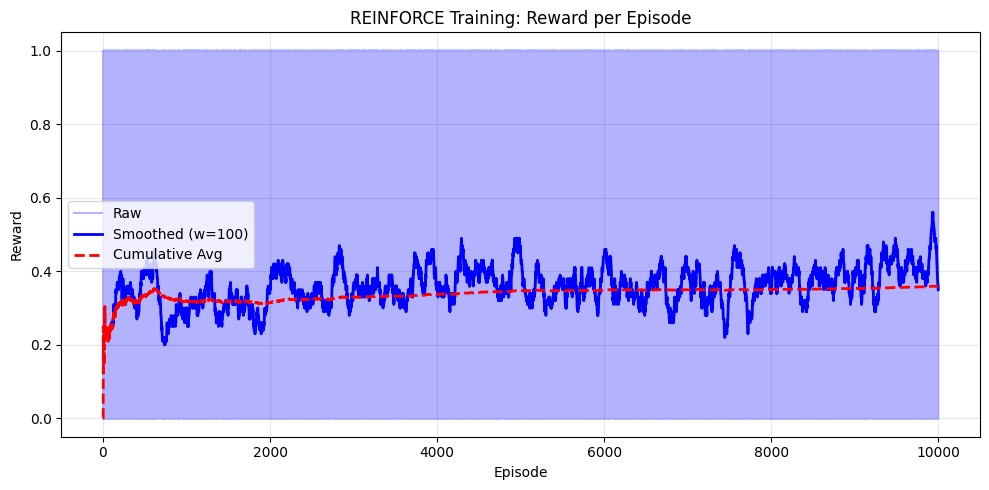

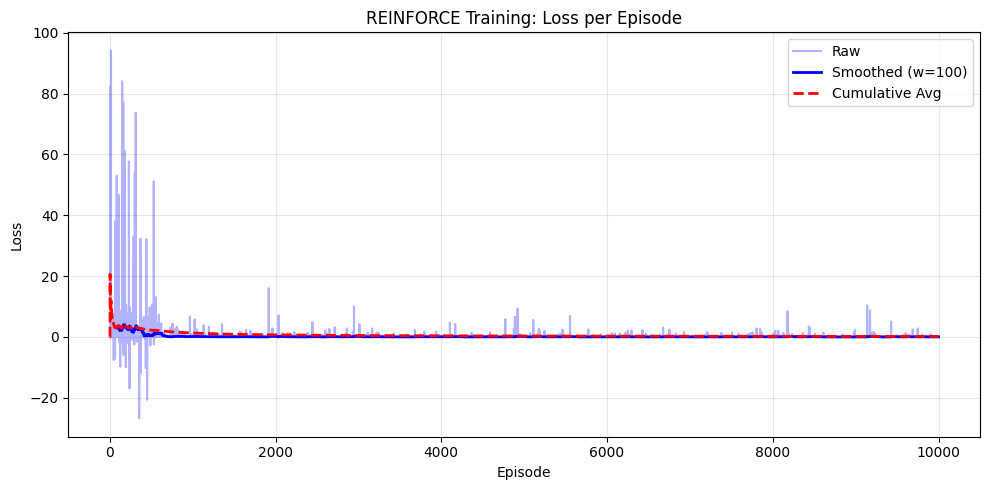

np.float64(0.17251142987012863)

In [11]:
print("\n" + "="*50)
print("REINFORCE TRAINING")
print("="*50)

env = SearchR1Environment(retriever)
trainer = SearchR1ReinforceTrainer(policy, optimizer, env, GAMMA)

train_losses = []
train_rewards = []
indices = list(range(len(questions)))
np.random.shuffle(indices)

for episode in range(NUM_EPISODES):
    if episode % len(questions) == 0:
        np.random.shuffle(indices)
    idx = indices[episode % len(questions)]

    loss, reward = trainer.train_step(questions[idx], answers[idx])
    train_losses.append(loss)
    train_rewards.append(reward)

    if (episode + 1) % PRINT_EVERY == 0:
        avg_loss = sum(train_losses[-PRINT_EVERY:]) / PRINT_EVERY
        avg_reward = sum(train_rewards[-PRINT_EVERY:]) / PRINT_EVERY
        print(f"Episode {episode+1}/{NUM_EPISODES} | Loss: {avg_loss:.4f} | Reward: {avg_reward:.4f}")

    if (episode + 1) % SAVE_EVERY == 0:
        ckpt_path = f"{SAVE_DIR}/episode_{episode+1}"
        model.save_pretrained(ckpt_path)
        tokenizer.save_pretrained(ckpt_path)
        print(f"Saved: {ckpt_path}")

ckpt_path = f"{SAVE_DIR}/final"
model.save_pretrained(ckpt_path)
tokenizer.save_pretrained(ckpt_path)

print("\n Training Complete")
plot_results(train_rewards, "REINFORCE Training: Reward per Episode", "Episode", "Reward", 100, f"{SAVE_DIR}/train_rewards.png")
plot_results(train_losses, "REINFORCE Training: Loss per Episode", "Episode", "Loss", 100, f"{SAVE_DIR}/train_losses.png")


=== EVALUATION (Sampling=True) ===

--- Episode 1 Debug ---
Q: Who was the Queen consort of King George the Fourth of England?
Trace: ['Step 0: answer -> Victoria']
Reward: 0.0
Ground Truth: Caroline of Brunswick

--- Episode 2 Debug ---
Q: Eliza Manningham Buller was the former Director General of which organisation?
Trace: ['Step 0: answer -> NSA']
Reward: 0.0
Ground Truth: MI5

--- Episode 3 Debug ---
Q: In heraldry, what term describes figures standing on either side of a shield as if upholding it and guarding it?
Trace: ['Step 0: answer -> supporters']
Reward: 1.0
Ground Truth: SUPPORTERS

--- Episode 4 Debug ---
Q: What nursery rhyme character “runs through the town, Up stairs and down stairs in his night-gown, Tapping at the window, crying at the lock, Are the children in their bed, for it’s past ten o’clock?”
Trace: ['Step 0: answer -> Mary Mary Quite Contrary']
Reward: 0.0
Ground Truth: Wee Willie Winkie

--- Episode 5 Debug ---
Q: What is the biggest selling copyright book e

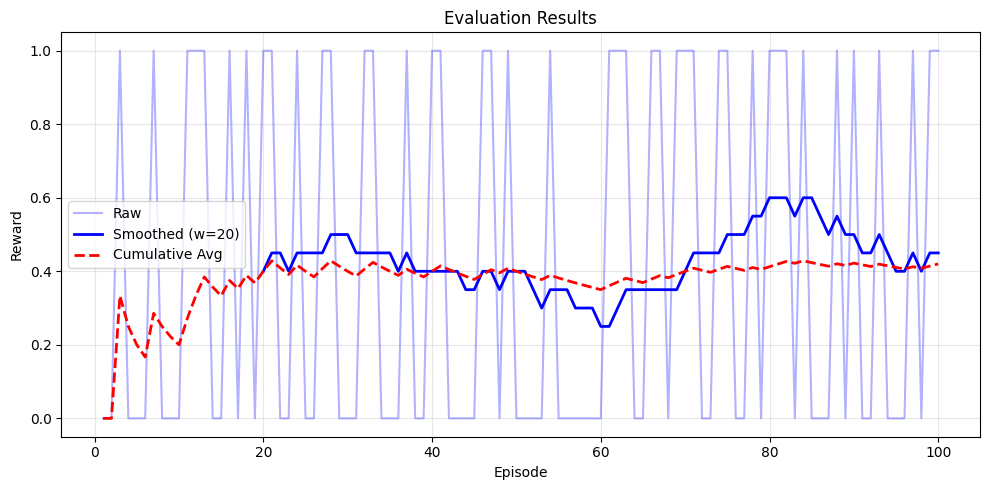

np.float64(0.42)

In [14]:
USE_SAMPLING = True   
DEBUG_PRINT = True    
NUM_TEST = 100


NUM_TEST_EPISODES = len(test_questions)
MAX_STEPS = 5

test_questions = test_questions[:100]
test_answers = test_answers[:100]

test_rewards = []
model.eval()

print(f"\n=== EVALUATION (Sampling={USE_SAMPLING}) ===")

def generate_answer(prompt, use_sampling=False):
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_SEQ_LEN,
        padding=False
    ).to(policy.device)

    with torch.no_grad():
        outputs = policy.model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_new_tokens=GENERATE_LEN,
            do_sample=use_sampling,
            temperature=1.0 if use_sampling else None,
            top_p=0.9 if use_sampling else None,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    gen_seq = outputs[0][inputs['input_ids'].shape[1]:]
    text = tokenizer.decode(gen_seq, skip_special_tokens=True)
    return text

for episode in range(NUM_TEST_EPISODES):
    state = env.reset(test_questions[episode], test_answers[episode])
    episode_reward = 0.0
    full_trace = []

    for step in range(MAX_STEPS):
        action_text = generate_answer(state, use_sampling=USE_SAMPLING)

        action = trainer.parse_action(action_text)
        state, reward, done = env.step(action)

        full_trace.append(f"Step {step}: {action['type']} -> {action['content']}")
        episode_reward += reward

        if done:
            break

    test_rewards.append(episode_reward)

    if DEBUG_PRINT and episode < 5:
        print(f"\n--- Episode {episode+1} Debug ---")
        print(f"Q: {test_questions[episode]}")
        print(f"Trace: {full_trace}")
        print(f"Reward: {episode_reward}")
        print(f"Ground Truth: {test_answers[episode]}") 

    if (episode + 1) % 10 == 0:
        avg_current = sum(test_rewards) / len(test_rewards)
        print(f"Test Episode {episode+1}/{NUM_TEST_EPISODES} | Current Avg Accuracy: {avg_current:.4f}")

final_avg = sum(test_rewards) / len(test_rewards)
print(f"\n✓ Evaluation Complete")
print(f"  Avg Reward (Accuracy): {final_avg:.4f}")
print(f"  Success Rate: {final_avg * 100:.2f}%")

plot_results(test_rewards, "Evaluation Results", "Episode", "Reward", 20, f"{SAVE_DIR}/test_rewards_fixed.png")